In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import prepare 

In [2]:
df = pd.read_csv('https://ds.codeup.com/saas.csv')

In [3]:
fmt = '%Y-%m-%d'

df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced, format=fmt)

df = df.set_index('Month_Invoiced')

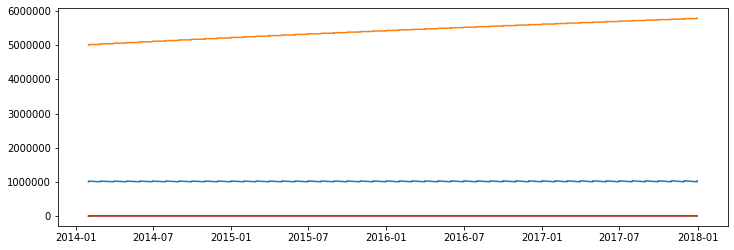

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(df)
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


### Resample by any period, except daily, and aggregate using the sum.

In [ ]:
#Weekly
weekly_df = df[['Amount','Subscription_Type']].resample('W').sum()

In [6]:
#Monthly
monthly_df = df[['Amount','Subscription_Type']].resample('M').sum()

### Split data (train/test) 

In [7]:
#This is a number that represents the row that is the last row of the first 66% of the dataset.
train_size = int(len(monthly_df) * 0.66)
#This makes Train 0---(1-train size) and Test (train_size -- -1)
train, test = monthly_df[0:train_size], monthly_df[train_size:len(df)]
print('Observations: %d' % (len(monthly_df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 31
Testing Observations: 17


In [8]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [9]:
def append_eval_df(model_type, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in ['sale_amount', 'item_sales']], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

### Forecast, plot and evaluate using each of the 4 parametric based methods:
    
    Simple Average
    Moving Average
    Holt's Linear Trend Model
    Based on previous year/month/etc., this is up to you.

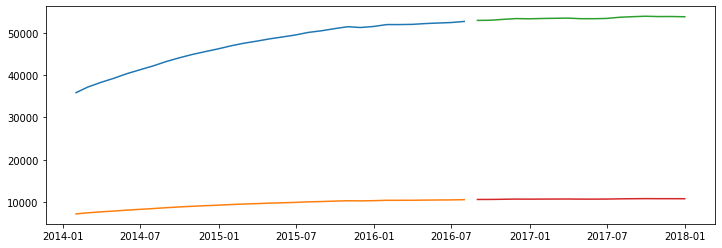

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)
plt.show()

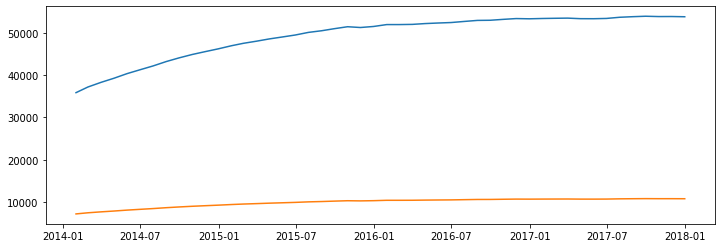

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(monthly_df)
plt.show()

In [12]:
#Create evalu df to hold the modeling scores
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])

In [ ]:
train.info()

In [14]:
forecasts = pd.DataFrame(test.Amount)

In [15]:
#Last Observed
forecasts['Last'] = int(train.Amount[-1:])

In [16]:
forecasts.head()

,Amount,Last
Month_Invoiced,,
2016-08-31,52940.0,52695
2016-09-30,52975.0,52695
2016-10-31,53190.0,52695
2016-11-30,53375.0,52695
2016-12-31,53320.0,52695


In [17]:
#Simple average
forecasts['simple_average'] = train.Amount.mean()

In [18]:
#Moving Average
forecasts['last_5_months_rollingAVG'] = train.Amount.rolling(5).mean().iloc[-1]

# MSE FOR SIMPLE AVERAGE

In [21]:
mse = metrics.mean_squared_error(test['Amount'], forecasts['simple_average'])

In [22]:
rmse = math.sqrt(mse)

In [23]:
mse

41153969.15284323

In [24]:
rmse

6415.135941883323

# MSE FOR MOVING AVERAGE

In [25]:
mse_movingAVG = metrics.mean_squared_error(test['Amount'], forecasts['last_5_months_rollingAVG'])

In [26]:
rmse_movingAVG = math.sqrt(mse_movingAVG)

In [27]:
mse_movingAVG

1409261.5882352942

In [28]:
rmse_movingAVG

1187.1232405421495